In [1]:
%reset #clear the ipython workspace variables

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  #clear, please run `%reset?` for details
Don't know how to reset  the, please run `%reset?` for details
Don't know how to reset  ipython, please run `%reset?` for details
Don't know how to reset  workspace, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details


In [2]:
#select that same tensorflow version as Training Script
%tensorflow_version 2.x

In [3]:
#Import Statements
import os
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec


from sklearn.preprocessing import MinMaxScaler
from numpy import array
import joblib
import sys

import math
from math import sqrt

import tensorflow as tf
from tensorflow.python.client import device_lib



In [4]:
#let ping the GPU and see what colab gave us...
print(tf.test.gpu_device_name())
print(device_lib.list_local_devices())

#let's also check version of tf and if eager is on.
print(tf.executing_eagerly())
print(tf.__version__)
print(keras.__version__)


/device:GPU:0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17080155214855558442
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15395979264
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11633286133793605939
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
]
True
2.5.0
2.5.0


In [5]:
#Change plot settings
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['font.size'] = 15
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2

In [6]:
#data is on google drive so need to load
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#this line needs to be changed depending on file structure of google drive
os.chdir('/content/drive/MyDrive/New LSTM Crack')

# Functions

In [8]:
def read_file(file_name):
  file = file_name
  return pd.read_csv(file)

In [9]:
def create_prediction_data(prediction_data):
  data_array = np.asarray(prediction_data)
  
  temp_data = data_array[:, 0]
  temp_series = (temp_data / np.amax(temp_data)).reshape(len(data_array), 1)

  stress_intensity = Scaler.transform(data_array[:, 1].reshape(len(data_array), 1))

  return np.hstack((temp_series, stress_intensity))

In [10]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern. copy in groups?
		seq_x, seq_y = sequences[i:end_ix, 1:], sequences[end_ix, 0]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [11]:
def create_actual_data(file_name):
  file = pd.read_csv(file_name)
  data_array = np.asarray(file)
  crack_length = data_array[:, 1]
  return crack_length

In [12]:
def create_da_dk_intermediate(case, stress_intensity, change):
  da = []
  dk = []
  
  for i in range(len(case) - change):
    da.append(case[i + change] - case[i])

  for i in range(len(stress_intensity) - change):
    dk.append(stress_intensity[i + change] - stress_intensity[i])

  return np.log(np.asarray(da)), np.log(np.asarray(dk))

In [13]:
def create_da_dk_actual(filename, crack_length, change):
  file = pd.read_csv(filename)
  data_array = np.asarray(file)

  stress_intensity = data_array[:, 1].reshape(len(data_array), 1)
  stress_intensity = Scaler.transform(stress_intensity)

  da = []
  dk = []

  for i in range(len(crack_length) - change):
    da.append(crack_length[i + change] - crack_length[i])

  for i in range(len(stress_intensity) - change):
    dk.append(stress_intensity[i + change] - stress_intensity[i])

  return np.log(np.asarray(da)), np.log(np.asarray(dk))

# Loading Data

In [14]:
#Load previously trained model
model = keras.models.load_model("./Weights/WorkingSave_TM/Model_HT_5_21_21_TM")
print("Model Loaded")

Model Loaded


In [15]:
#Load in the experimental data
#['./Training/HeatTreated/t150_4-12-21_R05_1800N_training.csv', './Training/HeatTreated/t150_4-13-21_R05_1700N_training.csv', 
#'./Training/HeatTreated/t150_4-15-21_R05_1600N_training.csv', './Training/HeatTreated/t250_4-21-21_R05_1800N_training.csv', 
#'./Training/HeatTreated/t250_4-7-21_R05_1700N_training.csv', './Training/HeatTreated/t250_4-8-21_R05_1600N_training.csv', 
#'./Training/HeatTreated/t35_4-19-21_R05_1800N_training.csv', './Training/HeatTreated/t35_4-2-21_R05_1700N_training.csv']

data_1600_35 = np.asarray(pd.read_csv('./Training/HeatTreated/hold/t35_4-3-21_R05_1600N_training.bak'))
data_1700_35 = np.asarray(pd.read_csv('./Training/HeatTreated/t35_4-2-21_R05_1700N_training.csv'))
data_1800_35 = np.asarray(pd.read_csv('./Training/HeatTreated/t35_4-19-21_R05_1800N_training.csv'))

data_1600_150 = np.asarray(pd.read_csv('./Training/HeatTreated/t150_4-15-21_R05_1600N_training.csv'))
data_1700_150 = np.asarray(pd.read_csv('./Training/HeatTreated/t150_4-13-21_R05_1700N_training.csv'))
data_1800_150 = np.asarray(pd.read_csv('./Training/HeatTreated/t150_4-12-21_R05_1800N_training.csv'))

data_1600_250 = np.asarray(pd.read_csv('./Training/HeatTreated/t250_4-8-21_R05_1600N_training.csv'))
data_1700_250 = np.asarray(pd.read_csv('./Training/HeatTreated/t250_4-7-21_R05_1700N_training.csv'))
data_1800_250 = np.asarray(pd.read_csv('./Training/HeatTreated/t250_4-21-21_R05_1800N_training.csv'))

#Load in the extrapolated data
#75C
data_1600_75 = np.asarray(pd.read_csv('./Predict/HeatTreated/1600N_HT_348K_noise.csv'))
data_1700_75 = np.asarray(pd.read_csv('./Predict/HeatTreated/1700N_HT_348K_noise.csv'))
data_1800_75 = np.asarray(pd.read_csv('./Predict/HeatTreated/1800N_HT_348K_noise.csv'))
#200C
data_1600_200 = np.asarray(pd.read_csv('./Predict/HeatTreated/1600N_HT_473K_noise.csv'))
data_1700_200 = np.asarray(pd.read_csv('./Predict/HeatTreated/1700N_HT_473K_noise.csv'))
data_1800_200 = np.asarray(pd.read_csv('./Predict/HeatTreated/1800N_HT_473K_noise.csv'))
#300C
data_1600_300 = np.asarray(pd.read_csv('./Predict/HeatTreated/1600N_HT_573K_noise.csv'))
data_1700_300 = np.asarray(pd.read_csv('./Predict/HeatTreated/1700N_HT_573K_noise.csv'))
data_1800_300 = np.asarray(pd.read_csv('./Predict/HeatTreated/1800N_HT_573K_noise.csv'))
#400C
data_1600_400 = np.asarray(pd.read_csv('./Predict/HeatTreated/1600N_HT_673K_noise.csv'))
data_1700_400 = np.asarray(pd.read_csv('./Predict/HeatTreated/1700N_HT_673K_noise.csv'))
data_1800_400 = np.asarray(pd.read_csv('./Predict/HeatTreated/1800N_HT_673K_noise.csv'))
#500C
data_1600_500 = np.asarray(pd.read_csv('./Predict/HeatTreated/1600N_HT_773K_noise.csv'))
data_1700_500 = np.asarray(pd.read_csv('./Predict/HeatTreated/1700N_HT_773K_noise.csv'))
data_1800_500 = np.asarray(pd.read_csv('./Predict/HeatTreated/1800N_HT_773K_noise.csv'))
print('Data Loaded')

Data Loaded


In [16]:
#need to adjust data for restart cases
data_1600_150 = data_1600_150 - 0.4 # 1600 150C
data_1800_35 = data_1800_35 - 0.6 #1800 35C
data_1800_250 = data_1800_250 - 0.6 # 1800N 250C

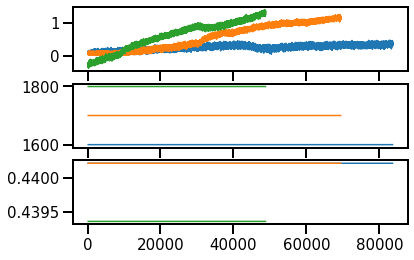

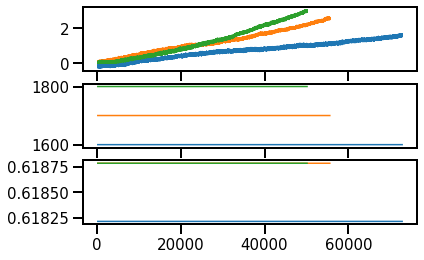

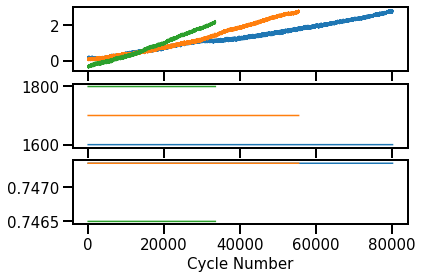

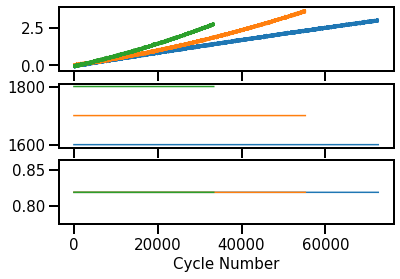

In [17]:
# time
time_1600_35 = data_1600_35[:,0];time_1700_35 = data_1700_35[:,0];time_1800_35 = data_1800_35[:,0]
time_1600_150 = data_1600_150[:,0];time_1700_150 = data_1700_150[:,0];time_1800_150 = data_1800_150[:,0]
time_1600_250 = data_1600_250[:,0];time_1700_250 = data_1700_250[:,0];time_1800_250 = data_1800_250[:,0]
#extrapolated data
time_1600_75 = data_1600_75[:,0];time_1700_75 = data_1700_75[:,0];time_1800_75 = data_1800_75[:,0]
time_1600_200 = data_1600_200[:,0];time_1700_200 = data_1700_200[:,0];time_1800_200 = data_1800_200[:,0]
time_1600_300 = data_1600_300[:,0];time_1700_300 = data_1700_300[:,0];time_1800_300 = data_1800_300[:,0]
time_1600_400 = data_1600_400[:,0];time_1700_400 = data_1700_400[:,0];time_1800_400 = data_1800_400[:,0]
time_1600_500 = data_1600_500[:,0];time_1700_500 = data_1700_500[:,0];time_1800_500 = data_1800_500[:,0]

# crack length
crack_1600_35 = data_1600_35[:,1];crack_1700_35 = data_1700_35[:,1];crack_1800_35 = data_1800_35[:,1]
crack_1600_150 = data_1600_150[:,1];crack_1700_150 = data_1700_150[:,1];crack_1800_150 = data_1800_150[:,1]
crack_1600_250 = data_1600_250[:,1];crack_1700_250 = data_1700_250[:,1];crack_1800_250 = data_1800_250[:,1]
#extrapolated data
crack_1600_75 = data_1600_75[:,1];crack_1700_75 = data_1700_75[:,1];crack_1800_75 = data_1800_75[:,1]
crack_1600_200 = data_1600_200[:,1];crack_1700_200 = data_1700_200[:,1];crack_1800_200 = data_1800_200[:,1]
crack_1600_300 = data_1600_300[:,1];crack_1700_300 = data_1700_300[:,1];crack_1800_300 = data_1800_300[:,1]
crack_1600_400 = data_1600_400[:,1];crack_1700_400 = data_1700_400[:,1];crack_1800_400 = data_1800_400[:,1]
crack_1600_500 = data_1600_500[:,1];crack_1700_500 = data_1700_500[:,1];crack_1800_500 = data_1800_500[:,1]

# force
force_1600_35 = data_1600_35[:,2];force_1700_35 = data_1700_35[:,2];force_1800_35 = data_1800_35[:,2]
force_1600_150 = data_1600_150[:,2];force_1700_150 = data_1700_150[:,2];force_1800_150 = data_1800_150[:,2]
force_1600_250 = data_1600_250[:,2];force_1700_250 = data_1700_250[:,2];force_1800_250 = data_1800_250[:,2]
#extrapolated data
force_1600_75 = data_1600_75[:,2];force_1700_75 = data_1700_75[:,2];force_1800_75 = data_1800_75[:,2]
force_1600_200 = data_1600_200[:,2];force_1700_200 = data_1700_200[:,2];force_1800_200 = data_1800_200[:,2]
force_1600_300 = data_1600_300[:,2];force_1700_300 = data_1700_300[:,2];force_1800_300 = data_1800_300[:,2]
force_1600_400 = data_1600_400[:,2];force_1700_400 = data_1700_400[:,2];force_1800_400 = data_1800_400[:,2]
force_1600_500 = data_1600_500[:,2];force_1700_500 = data_1700_500[:,2];force_1800_500 = data_1800_500[:,2]

# normalize the temperature series data by 700K
temp_1600_35 = data_1600_35[:,3]/700;temp_1700_35 = data_1700_35[:,3]/700;temp_1800_35 = data_1800_35[:,3]/700
temp_1600_150 = data_1600_150[:,3]/700;temp_1700_150 = data_1700_150[:,3]/700;temp_1800_150 = data_1800_150[:,3]/700
temp_1600_250 = data_1600_250[:,3]/700;temp_1700_250 = data_1700_250[:,3]/700;temp_1800_250 = data_1800_250[:,3]/700
#extrapolated data
temp_1600_75 = data_1600_300[:,3]/700;temp_1700_75 = data_1700_75[:,3]/700;temp_1800_75 = data_1800_75[:,3]/700
temp_1600_200 = data_1600_200[:,3]/700;temp_1700_200 = data_1700_200[:,3]/700;temp_1800_200 = data_1800_200[:,3]/700
temp_1600_300 = data_1600_300[:,3]/700;temp_1700_300 = data_1700_300[:,3]/700;temp_1800_300 = data_1800_300[:,3]/700
temp_1600_400 = data_1600_400[:,3]/700;temp_1700_400 = data_1700_400[:,3]/700;temp_1800_400 = data_1800_400[:,3]/700
temp_1600_500 = data_1600_500[:,3]/700;temp_1700_500 = data_1700_500[:,3]/700;temp_1800_500 = data_1800_500[:,3]/700

#let's plot the data to see what is going on
fig, (ax1c1,ax2c1,ax3c1) = plt.subplots(3,1, sharex=True)
#Column 1
ax1c1.plot(time_1600_35[:,],crack_1600_35[:,], '-', label='35C 1600N') # 
ax1c1.plot(time_1700_35[:,],crack_1700_35[:,], '-', label='35C 1700N') # 
ax1c1.plot(time_1800_35[:,],crack_1800_35[:,], '-', label='35C 1800N') # 
ax2c1.plot(time_1600_35[:,],force_1600_35[:,], '-', label='35C 1600N')
ax2c1.plot(time_1700_35[:,],force_1700_35[:,], '-', label='35C 1700N')
ax2c1.plot(time_1800_35[:,],force_1800_35[:,], '-', label='35C 1800N')
ax3c1.plot(time_1600_35[:,],temp_1600_35[:,], '-', label='35C 1600N')
ax3c1.plot(time_1700_35[:,],temp_1700_35[:,], '-', label='35C 1700N')
ax3c1.plot(time_1800_35[:,],temp_1800_35[:,], '-', label='35C 1800N')

fig2, (ax1c2,ax2c2,ax3c2) = plt.subplots(3,1, sharex=True)
#Column 2
ax1c2.plot(time_1600_150[:,],crack_1600_150[:,], '-', label='150C 1600N') # 
ax1c2.plot(time_1700_150[:,],crack_1700_150[:,], '-', label='150C 1700N') # 
ax1c2.plot(time_1800_150[:,],crack_1800_150[:,], '-', label='150C 1800N') # 
ax2c2.plot(time_1600_150[:,],force_1600_150[:,], '-', label='150C 1600N')
ax2c2.plot(time_1700_150[:,],force_1700_150[:,], '-', label='150C 1700N')
ax2c2.plot(time_1800_150[:,],force_1800_150[:,], '-', label='150C 1800N')
ax3c2.plot(time_1600_150[:,],temp_1600_150[:,], '-', label='150C 1600N')
ax3c2.plot(time_1700_150[:,],temp_1700_150[:,], '-', label='150C 1700N')
ax3c2.plot(time_1800_150[:,],temp_1800_150[:,], '-', label='150C 1800N')

fig3, (ax1c3,ax2c3,ax3c3) = plt.subplots(3,1, sharex=True)
#Column 3
ax1c3.plot(time_1600_250[:,],crack_1600_250[:,], '-', label='250C 1600N') # 
ax1c3.plot(time_1700_250[:,],crack_1700_250[:,], '-', label='250C 1700N') # 
ax1c3.plot(time_1800_250[:,],crack_1800_250[:,], '-', label='250C 1800N') # 
ax2c3.plot(time_1600_250[:,],force_1600_250[:,], '-', label='250C 1600N')
ax2c3.plot(time_1700_250[:,],force_1700_250[:,], '-', label='250C 1700N')
ax2c3.plot(time_1800_250[:,],force_1800_250[:,], '-', label='250C 1800N')
ax3c3.plot(time_1600_250[:,],temp_1600_250[:,], '-', label='250C 1600N')
ax3c3.plot(time_1700_250[:,],temp_1700_250[:,], '-', label='250C 1700N')
ax3c3.plot(time_1800_250[:,],temp_1800_250[:,], '-', label='250C 1800N')
plt.xlabel('Cycle Number')
plt.show()

fig4, (ax1c4,ax2c4,ax3c4) = plt.subplots(3,1, sharex=True)
#Column 3
ax1c4.plot(time_1600_300[:,],crack_1600_300[:,], '-', label='300C 1600N') # 
ax1c4.plot(time_1700_300[:,],crack_1700_300[:,], '-', label='300C 1700N') # 
ax1c4.plot(time_1800_300[:,],crack_1800_300[:,], '-', label='300C 1800N') # 
ax2c4.plot(time_1600_300[:,],force_1600_300[:,], '-', label='300C 1600N')
ax2c4.plot(time_1700_300[:,],force_1700_300[:,], '-', label='300C 1700N')
ax2c4.plot(time_1800_300[:,],force_1800_300[:,], '-', label='300C 1800N')
ax3c4.plot(time_1600_300[:,],temp_1600_300[:,], '-', label='300C 1600N')
ax3c4.plot(time_1700_300[:,],temp_1700_300[:,], '-', label='300C 1700N')
ax3c4.plot(time_1800_300[:,],temp_1800_300[:,], '-', label='300C 1800N')
plt.xlabel('Cycle Number')
plt.show()

#so it looks like it is concatenated 1800,1700,1600(med temperature) then 1800,1700,1600(high temperature) then 1800,1700,1600 (room temperature)
#don't quite understand the order or reasoning. but let's see if it works.

In [18]:
#funtion to compute time step. we must maintain time step
def avg_timestep(time_series):
  diff = 0
  w=0
  for i in range(0,len(time_series)-1):
    diff += time_series[i+1,]-time_series[i,]
    if time_series[i+1,]-time_series[i,]>0.196 and w<3:
      print('Warning!! Timestep Change > 0.196',i,time_series[i+1,]-time_series[i,])
      w+=1

  return diff/len(time_series)

In [19]:
#funtion creates a timestep array
def timestep_arr(time_series):
  diff = 0
  ts = []
  for i in range(0,len(time_series)-1):
    diff = time_series[i+1,]-time_series[i,]
    ts.append(diff)
  return np.array(ts)

Warning!! Timestep Change > 0.196 511 39.45312999999999
Warning!! Timestep Change > 0.196 1023 39.64843999999994
Warning!! Timestep Change > 0.196 1535 39.45312000000001
Average Time Sampling - 35C 0.2721710833708496
Warning!! Timestep Change > 0.196 511 39.648439999999994
Warning!! Timestep Change > 0.196 1022 39.64844000000005
Warning!! Timestep Change > 0.196 1534 39.64844000000039
Average Time Sampling - 150C 0.27215111960049565
Warning!! Timestep Change > 0.196 511 39.45312000000001
Warning!! Timestep Change > 0.196 1023 39.648439999999994
Warning!! Timestep Change > 0.196 1535 39.45312999999999
Average Time Sampling - 250C 0.26750528976972354
Warning!! Timestep Change > 0.196 511 39.45313
Warning!! Timestep Change > 0.196 1023 39.45312999999993
Warning!! Timestep Change > 0.196 1535 39.453130000000044
Average Time Sampling - 300C 0.2718759130170022


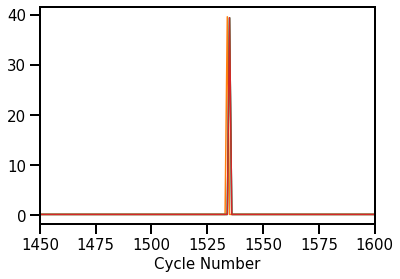

In [20]:
#let's check the time
#check time step
tstep_1600_35 = timestep_arr(time_1600_35)
tstep_1600_150 = timestep_arr(time_1600_150)
tstep_1600_200 = timestep_arr(time_1600_250)
#extrapolated
tstep_1600_75 = timestep_arr(time_1600_75)
tstep_1600_200 = timestep_arr(time_1600_200)
tstep_1600_300 = timestep_arr(time_1600_300)
tstep_1600_200 = timestep_arr(time_1600_400)
tstep_1600_300 = timestep_arr(time_1600_500)

print('Average Time Sampling - 35C',avg_timestep(time_1600_35))
print('Average Time Sampling - 150C',avg_timestep(time_1600_150))
print('Average Time Sampling - 250C',avg_timestep(time_1600_250))
print('Average Time Sampling - 300C',avg_timestep(time_1600_300))

#
fig5, (ax1c4) = plt.subplots(1,1, sharex=True)
#Column 3
ax1c4.plot(tstep_1600_35[:,], '-', label='35C 1600N') # 
ax1c4.plot(tstep_1600_150[:,], '-', label='150C 1600N') # 
ax1c4.plot(tstep_1600_200[:,], '-', label='200C 1600N') # 
ax1c4.plot(tstep_1600_300[:,], '-', label='300C 1600N') # 
ax1c4.set_xlim([1450, 1600])
plt.xlabel('Cycle Number')
plt.show()

In [21]:
def stress_intensity(force_series,crack_series):
  #Calculate the stress intensity
  #the geometry of the specimen had to be updated on 5/19/21
  si = []
  specimen_width = 34.63e-3 #meters #40.8 mm new width 34.63mm
  thickness = 0.4572e-3 #meters thickness of sample 0.4572mm
  a0 = 10e-3 #initial crack length is 10mm
  crossSectArea = (specimen_width-a0)*thickness #2.6388 meters 

  #looks like you are using the polynomial method derived from FEA to determine stress intensity  
  for i in range(len(crack_series)):
    if crack_series[i]>0.:
      term1 = (force_series[i] / crossSectArea) * sqrt(3.14 * crack_series[i])
      term2 = 8.574
      term3 = 10.365 * (crack_series[i] / specimen_width)
      term4 = 5.499 * ((crack_series[i] / specimen_width)**2)
      intensity = term1*(term2 - term3 + term4)
    else:
      intensity = 0.E-12

    si.append(intensity)
  return np.array(si)

In [22]:
#Read Scaler from Training
Scaler = MinMaxScaler()
Scaler = joblib.load('./Weights/WorkingSave_TM/Scaler_HT_TM.save')
print(Scaler.get_params)


<bound method BaseEstimator.get_params of MinMaxScaler(copy=True, feature_range=(0, 1))>


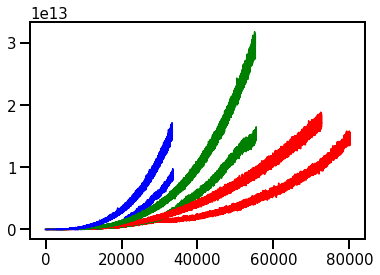

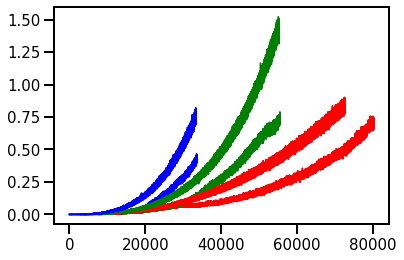

In [23]:
#Calculate the stress intensity - 35C
si_1600_35 = stress_intensity(force_1600_35,crack_1600_35)
si_1700_35 = stress_intensity(force_1700_35,crack_1700_35)
si_1800_35 = stress_intensity(force_1800_35,crack_1800_35)

#Calculate the stress intensity - 150C
si_1600_150 = stress_intensity(force_1600_150,crack_1600_150)
si_1700_150 = stress_intensity(force_1700_150,crack_1700_150)
si_1800_150 = stress_intensity(force_1800_150,crack_1800_150)

#Calculate the stress intensity - 150C
si_1600_250 = stress_intensity(force_1600_250,crack_1600_250)
si_1700_250 = stress_intensity(force_1700_250,crack_1700_250)
si_1800_250 = stress_intensity(force_1800_250,crack_1800_250)
#Extrapolated Data
#Calculate the stress intensity - 75C
si_1600_75 = stress_intensity(force_1600_75,crack_1600_75)
si_1700_75 = stress_intensity(force_1700_75,crack_1700_75)
si_1800_75 = stress_intensity(force_1800_75,crack_1800_75)

#Calculate the stress intensity - 200C
si_1600_200 = stress_intensity(force_1600_200,crack_1600_200)
si_1700_200 = stress_intensity(force_1700_200,crack_1700_200)
si_1800_200 = stress_intensity(force_1800_200,crack_1800_200)

#Calculate the stress intensity - 300C
si_1600_300 = stress_intensity(force_1600_300,crack_1600_300)
si_1700_300 = stress_intensity(force_1700_300,crack_1700_300)
si_1800_300 = stress_intensity(force_1800_300,crack_1800_300)

#Calculate the stress intensity - 400C
si_1600_400 = stress_intensity(force_1600_400,crack_1600_400)
si_1700_400 = stress_intensity(force_1700_400,crack_1700_400)
si_1800_400 = stress_intensity(force_1800_400,crack_1800_400)

#Calculate the stress intensity - 500C
si_1600_500 = stress_intensity(force_1600_500,crack_1600_500)
si_1700_500 = stress_intensity(force_1700_500,crack_1700_500)
si_1800_500 = stress_intensity(force_1800_500,crack_1800_500)


#plot before scaling
fig2, (ax1c1) = plt.subplots(1,1, sharex=True)
#Column 1
#ax1c1.plot(time_1600_35[:,],si_1600_35[:,], 'r-', label='35C 1600N') # 
#ax1c1.plot(time_1700_35[:,],si_1700_35[:,], 'g-', label='35C 1700N') # 
#ax1c1.plot(time_1800_35[:,],si_1800_35[:,], 'b-', label='35C 1800N') #

#ax1c1.plot(time_1600_150[:,],si_1600_150[:,], 'r-', label='150C 1600N') # 
#ax1c1.plot(time_1700_150[:,],si_1700_150[:,], 'g-', label='150C 1700N') # 
#ax1c1.plot(time_1800_150[:,],si_1800_150[:,], 'b-', label='150C 1800N') # 

ax1c1.plot(time_1600_250[:,],si_1600_250[:,], 'r-', label='250C 1600N') # 
ax1c1.plot(time_1700_250[:,],si_1700_250[:,], 'g-', label='250C 1700N') # 
ax1c1.plot(time_1800_250[:,],si_1800_250[:,], 'b-', label='250C 1800N') # 

ax1c1.plot(time_1600_300[:,],si_1600_300[:,], 'r-', label='300C 1600N Expl') # 
ax1c1.plot(time_1700_300[:,],si_1700_300[:,], 'g-', label='300C 1700N Expl') # 
ax1c1.plot(time_1800_300[:,],si_1800_300[:,], 'b-', label='300C 1800N Expl') # 

#scale stress intensity by same factor used during Training
si_1600_35 = Scaler.transform(si_1600_35.reshape((len(si_1600_35),1)))
si_1700_35 = Scaler.transform(si_1700_35.reshape((len(si_1700_35),1)))
si_1800_35 = Scaler.transform(si_1800_35.reshape((len(si_1800_35),1)))
#scale stress intensity by same factor used during Training
si_1600_150 = Scaler.transform(si_1600_150.reshape((len(si_1600_150),1)))
si_1700_150 = Scaler.transform(si_1700_150.reshape((len(si_1700_150),1)))
si_1800_150 = Scaler.transform(si_1800_150.reshape((len(si_1800_150),1)))
#scale stress intensity by same factor used during Training
si_1600_250 = Scaler.transform(si_1600_250.reshape((len(si_1600_250),1)))
si_1700_250 = Scaler.transform(si_1700_250.reshape((len(si_1700_250),1)))
si_1800_250 = Scaler.transform(si_1800_250.reshape((len(si_1800_250),1)))
#Extrapolated
#75C
si_1600_75 = Scaler.transform(si_1600_75.reshape((len(si_1600_75),1)))
si_1700_75 = Scaler.transform(si_1700_75.reshape((len(si_1700_75),1)))
si_1800_75 = Scaler.transform(si_1800_75.reshape((len(si_1800_75),1)))
#200C
si_1600_200 = Scaler.transform(si_1600_200.reshape((len(si_1600_200),1)))
si_1700_200 = Scaler.transform(si_1700_200.reshape((len(si_1700_200),1)))
si_1800_200 = Scaler.transform(si_1800_200.reshape((len(si_1800_200),1)))
#300C
si_1600_300 = Scaler.transform(si_1600_300.reshape((len(si_1600_300),1)))
si_1700_300 = Scaler.transform(si_1700_300.reshape((len(si_1700_300),1)))
si_1800_300 = Scaler.transform(si_1800_300.reshape((len(si_1800_300),1)))
#400C
si_1600_400 = Scaler.transform(si_1600_400.reshape((len(si_1600_400),1)))
si_1700_400 = Scaler.transform(si_1700_400.reshape((len(si_1700_400),1)))
si_1800_400 = Scaler.transform(si_1800_400.reshape((len(si_1800_400),1)))
#500C
si_1600_500 = Scaler.transform(si_1600_500.reshape((len(si_1600_500),1)))
si_1700_500 = Scaler.transform(si_1700_500.reshape((len(si_1700_500),1)))
si_1800_500 = Scaler.transform(si_1800_500.reshape((len(si_1800_500),1)))
#plot after scaling
fig2, (ax1c1) = plt.subplots(1,1, sharex=True)
#Column 1
#ax1c1.plot(time_1600_35[:,],si_1600_35[:,], 'r-', label='35C 1600N') # 
#ax1c1.plot(time_1700_35[:,],si_1700_35[:,], 'g-', label='35C 1700N') # 
#ax1c1.plot(time_1800_35[:,],si_1800_35[:,], 'b-', label='35C 1800N') #

#ax1c1.plot(time_1600_150[:,],si_1600_150[:,], 'r-', label='150C 1600N') # 
#ax1c1.plot(time_1700_150[:,],si_1700_150[:,], 'g-', label='150C 1700N') # 
#ax1c1.plot(time_1800_150[:,],si_1800_150[:,], 'b-', label='150C 1800N') # 

ax1c1.plot(time_1600_250[:,],si_1600_250[:,], 'r-', label='250C 1600N') # 
ax1c1.plot(time_1700_250[:,],si_1700_250[:,], 'g-', label='250C 1700N') # 
ax1c1.plot(time_1800_250[:,],si_1800_250[:,], 'b-', label='250C 1800N') # 

ax1c1.plot(time_1600_300[:,],si_1600_300[:,], 'r-', label='300C 1600N Expl') # 
ax1c1.plot(time_1700_300[:,],si_1700_300[:,], 'g-', label='300C 1700N Expl') # 
ax1c1.plot(time_1800_300[:,],si_1800_300[:,], 'b-', label='300C 1800N Expl') # 

In [24]:
#stack the data 
data_1600_35 = np.vstack((crack_1600_35, temp_1600_35, si_1600_35.reshape((len(si_1600_35),)))).swapaxes(0,1) #horizontal stack data
data_1700_35 = np.vstack((crack_1700_35, temp_1700_35, si_1700_35.reshape((len(si_1700_35),)))).swapaxes(0,1) #horizontal stack data
data_1800_35 = np.vstack((crack_1800_35, temp_1800_35, si_1800_35.reshape((len(si_1800_35),)))).swapaxes(0,1) #horizontal stack data

data_1600_150 = np.vstack((crack_1600_150, temp_1600_150, si_1600_150.reshape((len(si_1600_150),)))).swapaxes(0,1) #horizontal stack data
data_1700_150 = np.vstack((crack_1700_150, temp_1700_150, si_1700_150.reshape((len(si_1700_150),)))).swapaxes(0,1) #horizontal stack data
data_1800_150 = np.vstack((crack_1800_150, temp_1800_150, si_1800_150.reshape((len(si_1800_150),)))).swapaxes(0,1) #horizontal stack data

data_1600_250 = np.vstack((crack_1600_250, temp_1600_250, si_1600_250.reshape((len(si_1600_250),)))).swapaxes(0,1) #horizontal stack data
data_1700_250 = np.vstack((crack_1700_250, temp_1700_250, si_1700_250.reshape((len(si_1700_250),)))).swapaxes(0,1) #horizontal stack data
data_1800_250 = np.vstack((crack_1800_250, temp_1800_250, si_1800_250.reshape((len(si_1800_250),)))).swapaxes(0,1) #horizontal stack data
#extrapolated
#75C
data_1600_75 = np.vstack((crack_1600_75, temp_1600_75, si_1600_75.reshape((len(si_1600_75),)))).swapaxes(0,1) #horizontal stack data
data_1700_75 = np.vstack((crack_1700_75, temp_1700_75, si_1700_75.reshape((len(si_1700_75),)))).swapaxes(0,1) #horizontal stack data
data_1800_75 = np.vstack((crack_1800_75, temp_1800_75, si_1800_75.reshape((len(si_1800_75),)))).swapaxes(0,1) #horizontal stack data
#200C
data_1600_200 = np.vstack((crack_1600_200, temp_1600_200, si_1600_200.reshape((len(si_1600_200),)))).swapaxes(0,1) #horizontal stack data
data_1700_200 = np.vstack((crack_1700_200, temp_1700_200, si_1700_200.reshape((len(si_1700_200),)))).swapaxes(0,1) #horizontal stack data
data_1800_200 = np.vstack((crack_1800_200, temp_1800_200, si_1800_200.reshape((len(si_1800_200),)))).swapaxes(0,1) #horizontal stack data
#300C
data_1600_300 = np.vstack((crack_1600_300, temp_1600_300, si_1600_300.reshape((len(si_1600_300),)))).swapaxes(0,1) #horizontal stack data
data_1700_300 = np.vstack((crack_1700_300, temp_1700_300, si_1700_300.reshape((len(si_1700_300),)))).swapaxes(0,1) #horizontal stack data
data_1800_300 = np.vstack((crack_1800_300, temp_1800_300, si_1800_300.reshape((len(si_1800_300),)))).swapaxes(0,1) #horizontal stack data
#400C
data_1600_400 = np.vstack((crack_1600_400, temp_1600_400, si_1600_400.reshape((len(si_1600_400),)))).swapaxes(0,1) #horizontal stack data
data_1700_400 = np.vstack((crack_1700_400, temp_1700_400, si_1700_400.reshape((len(si_1700_400),)))).swapaxes(0,1) #horizontal stack data
data_1800_400 = np.vstack((crack_1800_400, temp_1800_400, si_1800_400.reshape((len(si_1800_400),)))).swapaxes(0,1) #horizontal stack data
#500C
data_1600_500 = np.vstack((crack_1600_500, temp_1600_500, si_1600_500.reshape((len(si_1600_500),)))).swapaxes(0,1) #horizontal stack data
data_1700_500 = np.vstack((crack_1700_500, temp_1700_500, si_1700_500.reshape((len(si_1700_500),)))).swapaxes(0,1) #horizontal stack data
data_1800_500 = np.vstack((crack_1800_500, temp_1800_500, si_1800_500.reshape((len(si_1800_500),)))).swapaxes(0,1) #horizontal stack data


# Create Prediction Data

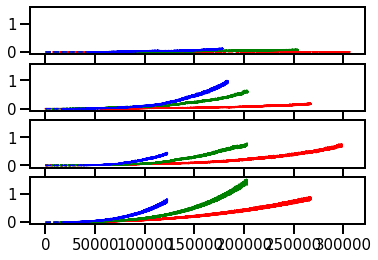

In [25]:
#split the sequences. [i1 i2 i3] [o4]
# temperature and stress intensity are inputs
n_steps = 3

xsplit_1600_35, ysplit_1600_35 = split_sequences(data_1600_35, n_steps)
xsplit_1700_35, ysplit_1700_35 = split_sequences(data_1700_35, n_steps)
xsplit_1800_35, ysplit_1800_35 = split_sequences(data_1800_35, n_steps)

xsplit_1600_150, ysplit_1600_150 = split_sequences(data_1600_150, n_steps)
xsplit_1700_150, ysplit_1700_150 = split_sequences(data_1700_150, n_steps)
xsplit_1800_150, ysplit_1800_150 = split_sequences(data_1800_150, n_steps)

xsplit_1600_250, ysplit_1600_250 = split_sequences(data_1600_250, n_steps)
xsplit_1700_250, ysplit_1700_250 = split_sequences(data_1700_250, n_steps)
xsplit_1800_250, ysplit_1800_250 = split_sequences(data_1800_250, n_steps)
#Extrapolated
#75C
xsplit_1600_75, ysplit_1600_75 = split_sequences(data_1600_75, n_steps)
xsplit_1700_75, ysplit_1700_75 = split_sequences(data_1700_75, n_steps)
xsplit_1800_75, ysplit_1800_75 = split_sequences(data_1800_75, n_steps)
#200C
xsplit_1600_200, ysplit_1600_200 = split_sequences(data_1600_200, n_steps)
xsplit_1700_200, ysplit_1700_200 = split_sequences(data_1700_200, n_steps)
xsplit_1800_200, ysplit_1800_200 = split_sequences(data_1800_200, n_steps)
#300C
xsplit_1600_300, ysplit_1600_300 = split_sequences(data_1600_300, n_steps)
xsplit_1700_300, ysplit_1700_300 = split_sequences(data_1700_300, n_steps)
xsplit_1800_300, ysplit_1800_300 = split_sequences(data_1800_300, n_steps)
#400C
xsplit_1600_400, ysplit_1600_400 = split_sequences(data_1600_400, n_steps)
xsplit_1700_400, ysplit_1700_400 = split_sequences(data_1700_400, n_steps)
xsplit_1800_400, ysplit_1800_400 = split_sequences(data_1800_400, n_steps)
#500C
xsplit_1600_500, ysplit_1600_500 = split_sequences(data_1600_500, n_steps)
xsplit_1700_500, ysplit_1700_500 = split_sequences(data_1700_500, n_steps)
xsplit_1800_500, ysplit_1800_500 = split_sequences(data_1800_500, n_steps)

fig, (ax,ax2,ax3,ax4) = plt.subplots(4,1,sharex=True,sharey=True)
ax.plot(xsplit_1600_35[:,0,1], 'r--', label='1600N 35C') # 
ax.plot(xsplit_1700_35[:,0,1], 'g--', label='1700N 35C')
ax.plot(xsplit_1800_35[:,0,1], 'b--', label='1800N 35C')
ax2.plot(xsplit_1600_150[:,0,1], 'r-', label='1600N 150C') # 
ax2.plot(xsplit_1700_150[:,0,1], 'g--', label='1700N 150C')
ax2.plot(xsplit_1800_150[:,0,1], 'b--', label='1800N 150C')
ax3.plot(xsplit_1600_250[:,0,1], 'r--', label='1600N 250C') # 
ax3.plot(xsplit_1700_250[:,0,1], 'g--', label='1700N 250C')
ax3.plot(xsplit_1800_250[:,0,1], 'b--', label='1800N 250C')
ax4.plot(xsplit_1600_300[:,0,1], 'r--', label='1600N 300C') # 
ax4.plot(xsplit_1700_300[:,0,1], 'g--', label='1700N 300C')
ax4.plot(xsplit_1800_300[:,0,1], 'b--', label='1800N 300C')
#ax.legend()
plt.show()

# Predict On Data

In [26]:
yhat1600_35 = model.predict(xsplit_1600_35, verbose=1)
yhat1700_35 = model.predict(xsplit_1700_35, verbose=1)
yhat1800_35 = model.predict(xsplit_1800_35, verbose=1)
print('35C FINISHED')

yhat1600_150 = model.predict(xsplit_1600_150, verbose=1)
yhat1700_150 = model.predict(xsplit_1700_150, verbose=1)
yhat1800_150 = model.predict(xsplit_1800_150, verbose=1)
print('150C FINISHED')

yhat1600_250 = model.predict(xsplit_1600_250, verbose=1)
yhat1700_250 = model.predict(xsplit_1700_250, verbose=1)
yhat1800_250 = model.predict(xsplit_1800_250, verbose=1)
print('250C FINISHED')

#Extrapolated Data
#75C
yhat1600_75 = model.predict(xsplit_1600_75, verbose=1)
yhat1700_75 = model.predict(xsplit_1700_75, verbose=1)
yhat1800_75 = model.predict(xsplit_1800_75, verbose=1)
print('75C FINISHED')
#200C
yhat1600_200 = model.predict(xsplit_1600_200, verbose=1)
yhat1700_200 = model.predict(xsplit_1700_200, verbose=1)
yhat1800_200 = model.predict(xsplit_1800_200, verbose=1)
print('2000C FINISHED')
#300C
yhat1600_300 = model.predict(xsplit_1600_300, verbose=1)
yhat1700_300 = model.predict(xsplit_1700_300, verbose=1)
yhat1800_300 = model.predict(xsplit_1800_300, verbose=1)
print('300C FINISHED')
#400C
yhat1600_400 = model.predict(xsplit_1600_400, verbose=1)
yhat1700_400 = model.predict(xsplit_1700_400, verbose=1)
yhat1800_400 = model.predict(xsplit_1800_400, verbose=1)
print('400C FINISHED')
#500C
yhat1600_500 = model.predict(xsplit_1600_500, verbose=1)
yhat1700_500 = model.predict(xsplit_1700_500, verbose=1)
yhat1800_500 = model.predict(xsplit_1800_500, verbose=1)
print('500C FINISHED')

5581/5581 [==============================] - 10s 2ms/step
35C FINISHED
5741/5741 [==============================] - 10s 2ms/step
150C FINISHED
3838/3838 [==============================] - 7s 2ms/step
250C FINISHED
3838/3838 [==============================] - 7s 2ms/step
75C FINISHED
3838/3838 [==============================] - 7s 2ms/step
2000C FINISHED
3838/3838 [==============================] - 7s 2ms/step
300C FINISHED
3838/3838 [==============================] - 7s 2ms/step
400C FINISHED
3838/3838 [==============================] - 7s 2ms/step
500C FINISHED


# Plotting With Actual Data

In [27]:
#read data in again to plot against prediction

cl1600_35 = create_actual_data('./Test/HeatTreated/t35_4-3-21_R05_1600N_testing.csv')
cl1700_35 = create_actual_data('./Test/HeatTreated/t35_4-2-21_R05_1700N_testing.csv')
cl1800_35 = create_actual_data('./Test/HeatTreated/t35_4-19-21_R05_1800N_testing.csv')

cl1600_150 = create_actual_data('./Test/HeatTreated/t150_4-15-21_R05_1600N_testing.csv')
cl1700_150 = create_actual_data('./Test/HeatTreated/t150_4-13-21_R05_1700N_testing.csv')
cl1800_150 = create_actual_data('./Test/HeatTreated/t150_4-12-21_R05_1800N_testing.csv')

cl1600_250 = create_actual_data('./Test/HeatTreated/t250_4-8-21_R05_1600N_testing.csv')
cl1700_250 = create_actual_data('./Test/HeatTreated/t250_4-7-21_R05_1700N_testing.csv')
cl1800_250 = create_actual_data('./Test/HeatTreated/t250_4-21-21_R05_1800N_testing.csv')

#need to adjust data for restart cases
cl1600_150 = cl1600_150 - 0.4 # 1600 150C
cl1800_35 = cl1800_35 - 0.6 #1800 35C
cl1800_250 = cl1800_250 - 0.6 # 1800N 250C

Plot against Original Data

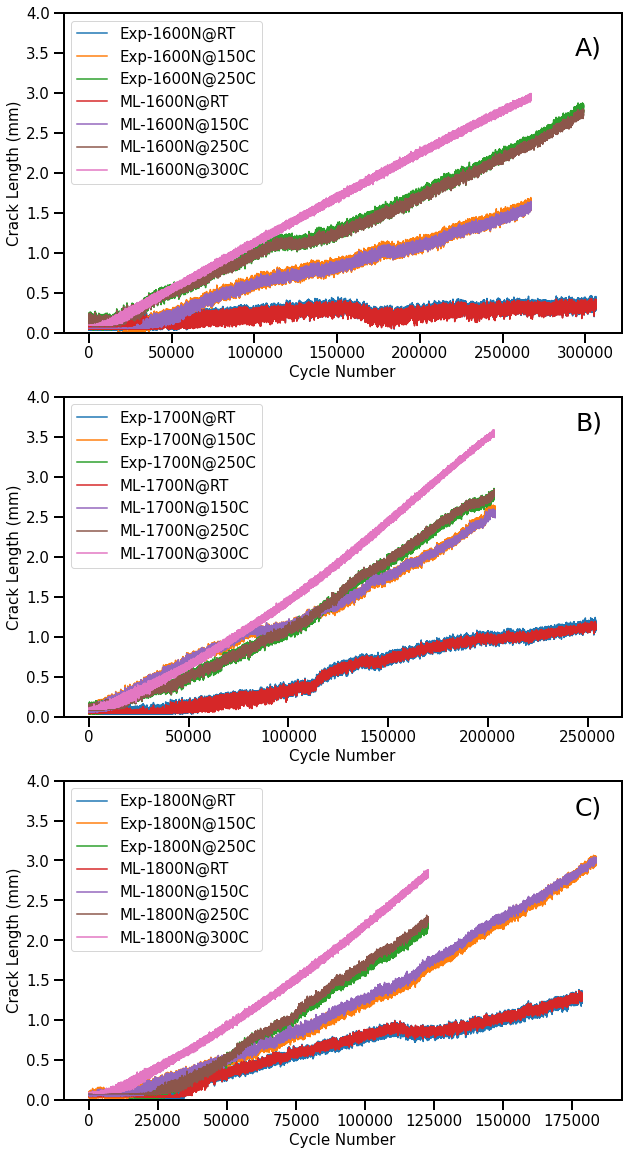

In [28]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,20))

ax1.plot(cl1600_35, label = 'Exp-1600N@RT')
ax1.plot(cl1600_150, label = 'Exp-1600N@150C')
ax1.plot(cl1600_250, label = 'Exp-1600N@250C')
ax1.plot(yhat1600_35, label = 'ML-1600N@RT')
ax1.plot(yhat1600_150, label = 'ML-1600N@150C')
ax1.plot(yhat1600_250, label = 'ML-1600N@250C')
ax1.plot(yhat1600_300, label = 'ML-1600N@300C')
ax1.set_xlabel("Cycle Number")
ax1.set_ylabel("Crack Length (mm)")
ax1.set_ylim([0, 4])
ax1.legend(loc=2)
ax1.annotate('A)',xy=(575, 1100), xycoords='figure points', fontsize=25, color='Black')

ax2.plot(cl1700_35, label = 'Exp-1700N@RT')
ax2.plot(cl1700_150, label = 'Exp-1700N@150C')
ax2.plot(cl1700_250, label = 'Exp-1700N@250C')
ax2.plot(yhat1700_35, label = 'ML-1700N@RT')
ax2.plot(yhat1700_150, label = 'ML-1700N@150C')
ax2.plot(yhat1700_250, label = 'ML-1700N@250C')
ax2.plot(yhat1700_300, label = 'ML-1700N@300C')
ax2.set_xlabel("Cycle Number")
ax2.set_ylabel("Crack Length (mm)")
ax2.legend()
ax2.set_ylim([0, 4])
ax2.annotate('B)',xy=(575, 725), xycoords='figure points', fontsize=25, color='Black')

ax3.plot(cl1800_35, label = 'Exp-1800N@RT')
ax3.plot(cl1800_150, label = 'Exp-1800N@150C')
ax3.plot(cl1800_250, label = 'Exp-1800N@250C')
ax3.plot(yhat1800_35, label = 'ML-1800N@RT')
ax3.plot(yhat1800_150, label = 'ML-1800N@150C')
ax3.plot(yhat1800_250, label = 'ML-1800N@250C')
ax3.plot(yhat1800_300, label = 'ML-1800N@300C')
ax3.set_xlabel('Cycle Number')
ax3.set_ylabel('Crack Length (mm)')
ax3.legend()
ax3.set_ylim([0, 4])
ax3.annotate('C)',xy=(575, 340), xycoords='figure points', fontsize=25, color='Black')

#ax3.xlabel("Cycle Number")
#ax1.ylabel("Crack Length (mm)")

plt.savefig('./Paper Images/CrackLength_vT_HT.pdf', format='pdf',bbox_inches='tight')

Paper Figure

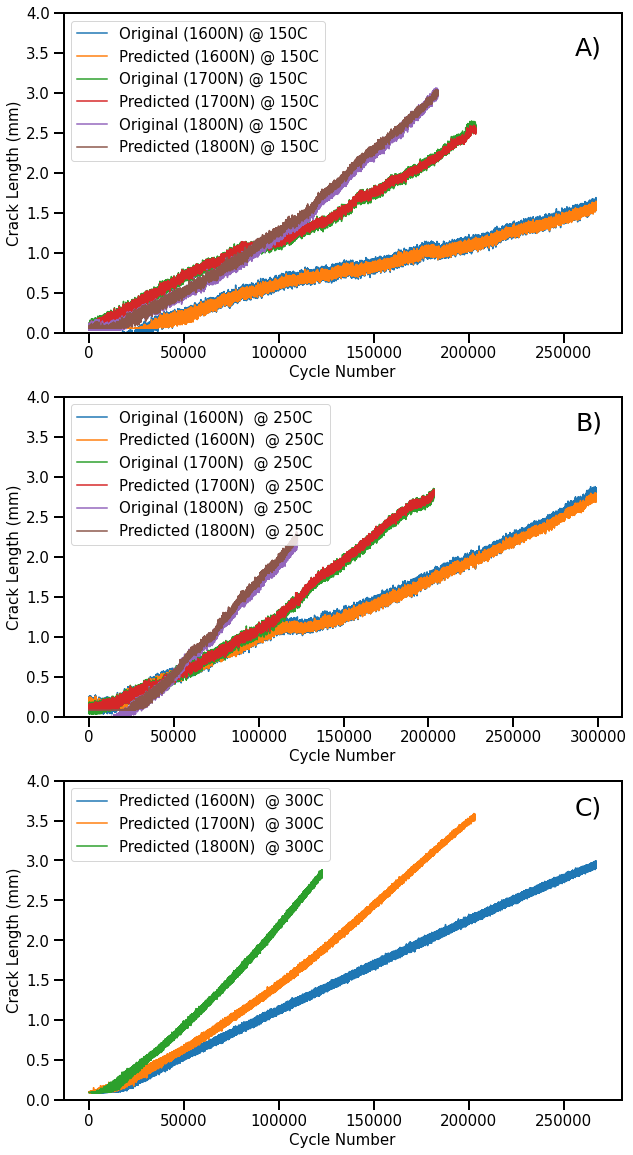

In [29]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,20))

#458K Data
ax1.plot(cl1600_150, label = 'Original (1600N) @ 150C')
ax1.plot(yhat1600_150, label = 'Predicted (1600N) @ 150C')
ax1.plot(cl1700_150, label = 'Original (1700N) @ 150C')
ax1.plot(yhat1700_150, label = 'Predicted (1700N) @ 150C')
ax1.plot(cl1800_150, label = 'Original (1800N) @ 150C')
ax1.plot(yhat1800_150, label = 'Predicted (1800N) @ 150C')
ax1.set_xlabel("Cycle Number")
ax1.set_ylabel("Crack Length (mm)")
ax1.set_ylim([0, 4])
ax1.legend(loc=2)
ax1.annotate('A)',xy=(575, 1100), xycoords='figure points', fontsize=25, color='Black')

#553K Data
ax2.plot(cl1600_250, label = 'Original (1600N)  @ 250C')
ax2.plot(yhat1600_250, label = 'Predicted (1600N)  @ 250C')
ax2.plot(cl1700_250, label = 'Original (1700N)  @ 250C')
ax2.plot(yhat1700_250, label = 'Predicted (1700N)  @ 250C')
ax2.plot(cl1800_250, label = 'Original (1800N)  @ 250C')
ax2.plot(yhat1800_250, label = 'Predicted (1800N)  @ 250C')
ax2.set_xlabel("Cycle Number")
ax2.set_ylabel("Crack Length (mm)")
ax2.legend()
ax2.set_ylim([0, 4])
ax2.annotate('B)',xy=(575, 725), xycoords='figure points', fontsize=25, color='Black')


#308K Data
ax3.plot(yhat1600_300, label = 'Predicted (1600N)  @ 300C')
ax3.plot(yhat1700_300, label = 'Predicted (1700N)  @ 300C')
ax3.plot(yhat1800_300, label = 'Predicted (1800N)  @ 300C')
ax3.set_xlabel('Cycle Number')
ax3.set_ylabel('Crack Length (mm)')
ax3.legend()
ax3.set_ylim([0, 4])
ax3.annotate('C)',xy=(575, 340), xycoords='figure points', fontsize=25, color='Black')

plt.savefig('./Paper Images/CrackLength_HT.pdf', format='pdf',bbox_inches='tight')

Heatmap

In [30]:
#Assemble arrays for 30C
min_arr = np.amin([len(yhat1600_35),len(yhat1700_35),len(yhat1800_35)])
arr_force = np.ones(min_arr).reshape(min_arr,1)
force_heatmap_35 = np.hstack((arr_force*1600,arr_force*1700,arr_force*1800))
crack_heatmap_35 = np.hstack((yhat1600_35[:min_arr,],yhat1700_35[:min_arr,],yhat1800_35[:min_arr,]))

arr_ti = np.arange(0,min_arr).reshape(min_arr,1)
time_heatmap_35 = np.hstack((arr_ti,arr_ti,arr_ti))

In [31]:
#Assemble arrays for 250C
min_arr = np.amin([len(yhat1600_250),len(yhat1700_250),len(yhat1800_250)])
arr_force = np.ones(min_arr).reshape(min_arr,1)
force_heatmap_250 = np.hstack((arr_force*1600,arr_force*1700,arr_force*1800))
crack_heatmap_250 = np.hstack((yhat1600_250[:min_arr,],yhat1700_250[:min_arr,],yhat1800_250[:min_arr,]))

arr_ti = np.arange(0,min_arr).reshape(min_arr,1)
time_heatmap_250 = np.hstack((arr_ti,arr_ti,arr_ti))

In [32]:
#Assemble arrays for 300C
min_arr = np.amin([len(yhat1600_300),len(yhat1700_300),len(yhat1800_300)])
arr_force = np.ones(min_arr).reshape(min_arr,1)
force_heatmap_300 = np.hstack((arr_force*1600,arr_force*1700,arr_force*1800))
crack_heatmap_300 = np.hstack((yhat1600_300[:min_arr,],yhat1700_300[:min_arr,],yhat1800_300[:min_arr,]))

arr_ti = np.arange(0,min_arr).reshape(min_arr,1)
time_heatmap_300 = np.hstack((arr_ti,arr_ti,arr_ti))

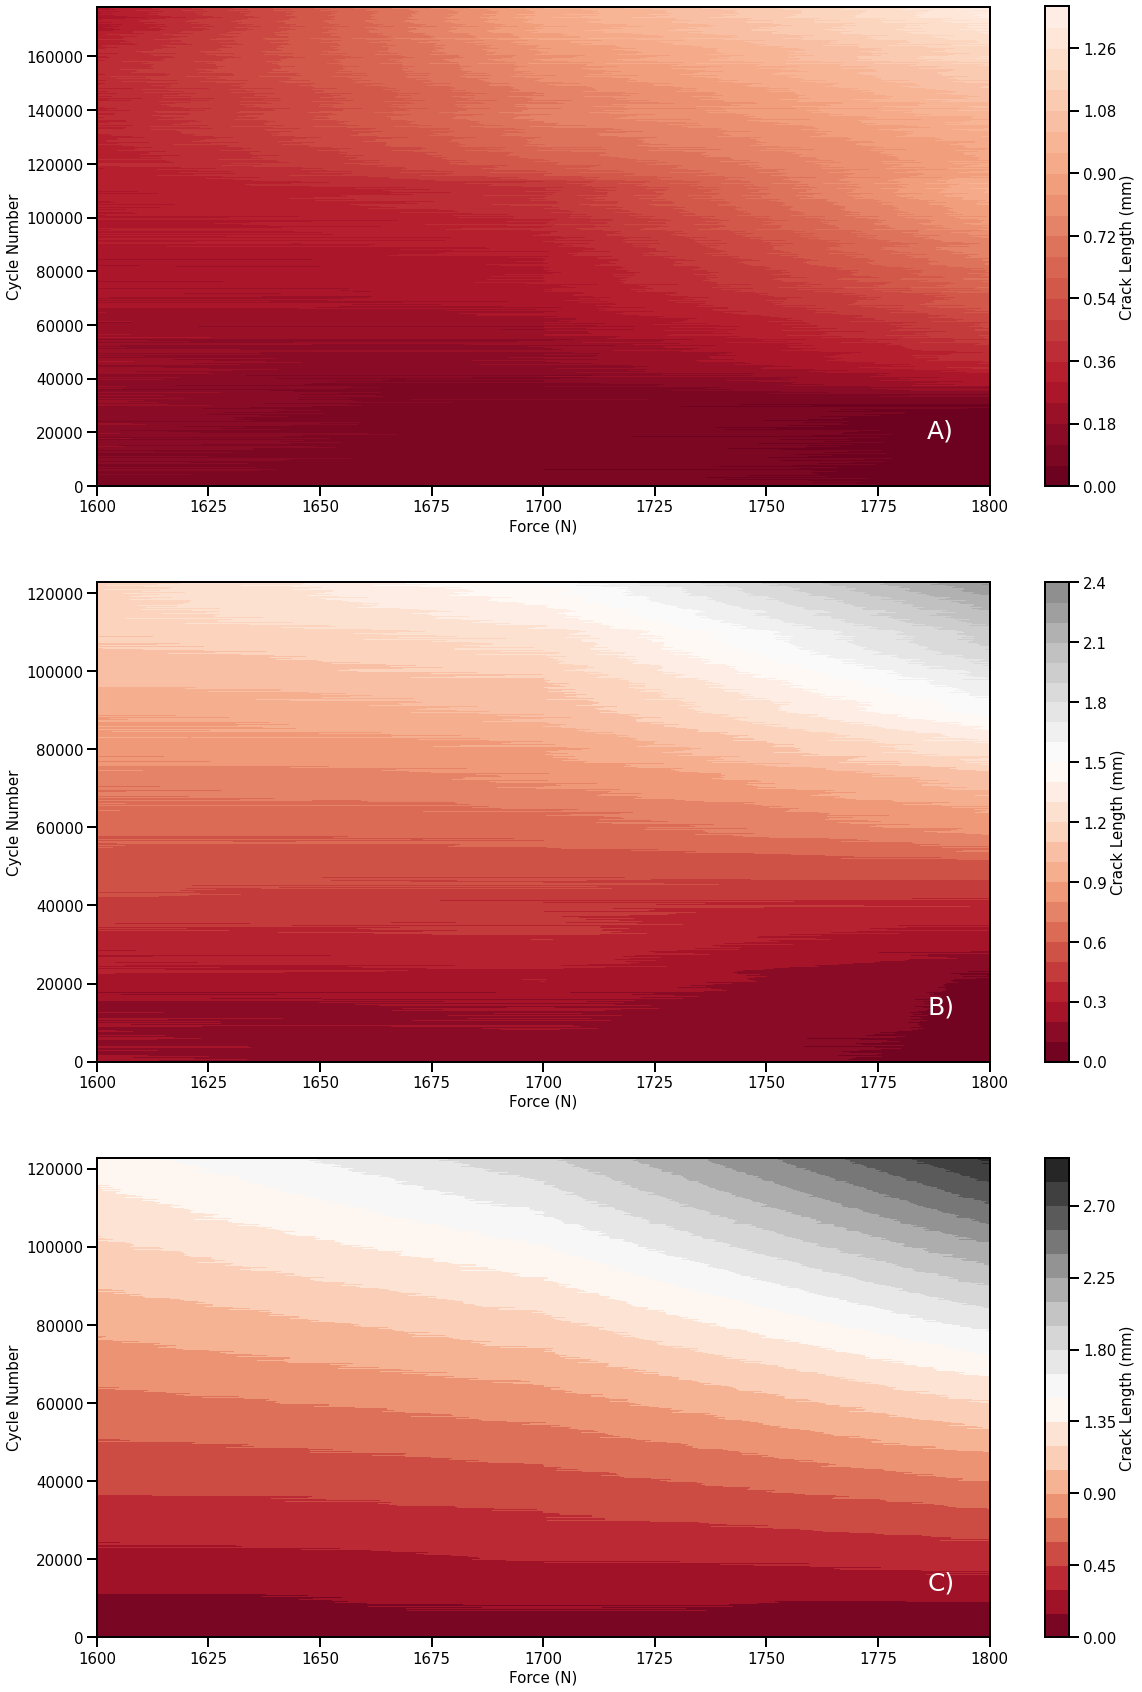

In [33]:
opts = {'vmin': 0, 'vmax': 3, 'cmap': 'RdGy', 'levels':23}
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,30))

plot1 = ax1.contourf(force_heatmap_35,time_heatmap_35,crack_heatmap_35, **opts)
ax1.set_xlabel("Force (N)")
ax1.set_ylabel("Cycle Number")
ax1.annotate('A)',xy=(.93, .10), xycoords='axes fraction', fontsize=25, color='white')

plot2 = ax2.contourf(force_heatmap_250,time_heatmap_250,crack_heatmap_250, **opts)
ax2.set_xlabel("Force (N)")
ax2.set_ylabel("Cycle Number")
ax2.annotate('B)',xy=(.93, .10), xycoords='axes fraction', fontsize=25, color='white')

plot3 = ax3.contourf(force_heatmap_300,time_heatmap_300,crack_heatmap_300, **opts)
ax3.set_xlabel("Force (N)")
ax3.set_ylabel("Cycle Number")
ax3.annotate('C)',xy=(.93, .10), xycoords='axes fraction', fontsize=25, color='white')


cbar1 = fig.colorbar(plot1, ax=ax1)
cbar1.set_label('Crack Length (mm)')
cbar2 = fig.colorbar(plot2, ax=ax2)
cbar2.set_label('Crack Length (mm)')
cbar3 = fig.colorbar(plot3, ax=ax3)
cbar3.set_label('Crack Length (mm)')

plt.savefig('./Paper Images/Heatmap_HT.pdf', format='pdf',bbox_inches='tight')

DaDn

In [34]:
change = 10000

da1600_250, dk1600_250 = create_da_dk_intermediate(yhat1600_250, cl1600_250, change)
da1700_250, dk1700_250 = create_da_dk_intermediate(yhat1700_250, cl1700_250, change)
da1800_250, dk1800_250 = create_da_dk_intermediate(yhat1800_250, cl1800_250, change)

da1600_150, dk1600_150 = create_da_dk_intermediate(yhat1600_150, cl1600_150, change)
da1700_150, dk1700_150 = create_da_dk_intermediate(yhat1700_150, cl1700_150, change)
da1800_150, dk1800_150 = create_da_dk_intermediate(yhat1800_150, cl1800_150, change)

da1600_35, dk1600_35 = create_da_dk_intermediate(yhat1600_35, cl1600_35, change)
da1700_35, dk1700_35 = create_da_dk_intermediate(yhat1700_35, cl1700_35, change)
da1800_35, dk1800_35 = create_da_dk_intermediate(yhat1800_35, cl1800_35, change)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [35]:
da1600_250_ts = da1600_250[0::1890]
da1700_250_ts = da1700_250[0::1890]
da1800_250_ts = da1800_250[0::1890]
dk1600_250_ts = dk1600_250[0::1890]
dk1700_250_ts = dk1700_250[0::1890]
dk1800_250_ts = dk1800_250[0::1890]

da1600_150_ts = da1600_150[0::1890]
da1700_150_ts = da1700_150[0::1890]
da1800_150_ts = da1800_150[0::1890]
dk1600_150_ts = dk1600_150[0::1890]
dk1700_150_ts = dk1700_150[0::1890]
dk1800_150_ts = dk1800_150[0::1890]

da1600_35_ts = da1600_35[0::1890]
da1700_35_ts = da1700_35[0::1890]
da1800_35_ts = da1800_35[0::1890]
dk1600_35_ts = dk1600_35[0::1890]
dk1700_35_ts = dk1700_35[0::1890]
dk1800_35_ts = dk1800_35[0::1890]

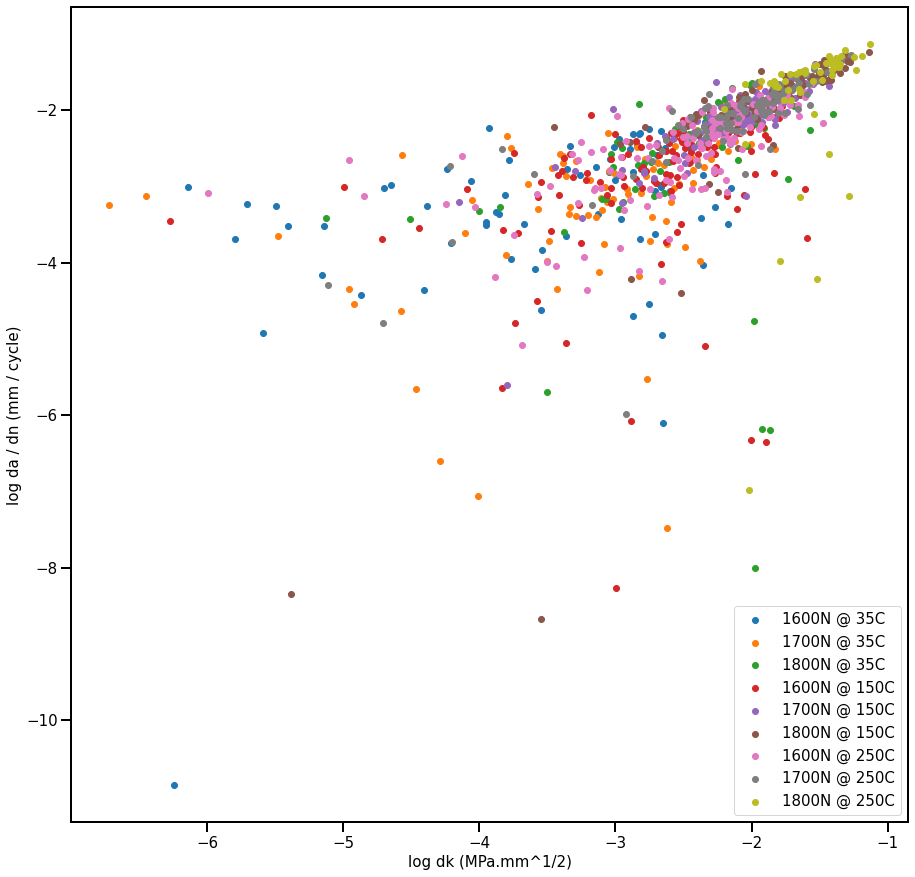

In [36]:
plt.figure(figsize=(15,15))
plt.scatter(dk1600_35_ts[:da1600_35_ts.shape[0]], da1600_35_ts, label = '1600N @ 35C')
plt.scatter(dk1700_35_ts[:da1700_35_ts.shape[0]], da1700_35_ts, label = '1700N @ 35C')
plt.scatter(dk1800_35_ts[:da1800_35_ts.shape[0]], da1800_35_ts, label = '1800N @ 35C')

plt.scatter(dk1600_150_ts[:da1600_150_ts.shape[0]], da1600_150_ts, label = '1600N @ 150C')
plt.scatter(dk1700_150_ts[:da1700_150_ts.shape[0]], da1700_150_ts, label = '1700N @ 150C')
plt.scatter(dk1800_150_ts[:da1800_150_ts.shape[0]], da1800_150_ts, label = '1800N @ 150C')

plt.scatter(dk1600_250_ts[:da1600_250_ts.shape[0]], da1600_250_ts, label = '1600N @ 250C')
plt.scatter(dk1700_250_ts[:da1700_250_ts.shape[0]], da1700_250_ts, label = '1700N @ 250C')
plt.scatter(dk1800_250_ts[:da1800_250_ts.shape[0]], da1800_250_ts, label = '1800N @ 250C')

plt.xlabel('log dk (MPa.mm^1/2)')
plt.ylabel('log da / dn (mm / cycle)')
plt.legend()
plt.savefig('./Paper Images/dadn_HT.pdf', format='pdf',bbox_inches='tight')